## Setup and Imports

In [1]:
import pandas as pd
from utilities import read_companys_dataset2018, read_base_dataset

In [2]:
# Read the dataset
pd.set_option('mode.use_inf_as_na', True) # convert inf to nan
base_df = read_base_dataset("2018")
# company_df = read_companys_dataset2018()

In [3]:
# Convert Labels to Binary Class
base_df['Label'] = base_df['Label'].apply(lambda x: 0 if 'Benign' in x else 1)
company_df.drop('Label', axis=1, inplace=True)

NameError: name 'company_df' is not defined

In [5]:
base_df.Label.unique()

array([0, 1])

In [6]:
base_df.columns

Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
      

In [7]:
extra_cols = ['Timestamp']
base_df.drop(extra_cols, axis=1, inplace=True)

In [8]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 79 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Dst Port           1048575 non-null  int64  
 1   Protocol           1048575 non-null  int64  
 2   Flow Duration      1048575 non-null  int64  
 3   Tot Fwd Pkts       1048575 non-null  int64  
 4   Tot Bwd Pkts       1048575 non-null  int64  
 5   TotLen Fwd Pkts    1048575 non-null  int64  
 6   TotLen Bwd Pkts    1048575 non-null  int64  
 7   Fwd Pkt Len Max    1048575 non-null  int64  
 8   Fwd Pkt Len Min    1048575 non-null  int64  
 9   Fwd Pkt Len Mean   1048575 non-null  float64
 10  Fwd Pkt Len Std    1048575 non-null  float64
 11  Bwd Pkt Len Max    1048575 non-null  int64  
 12  Bwd Pkt Len Min    1048575 non-null  int64  
 13  Bwd Pkt Len Mean   1048575 non-null  float64
 14  Bwd Pkt Len Std    1048575 non-null  float64
 15  Flow Byts/s        1048575 non-n

In [9]:
print("<< Base Dataset >>")
print("Original Size:", base_df.shape[0])
base_df.dropna(axis=0, inplace=True)
print("Reduced Size:", base_df.shape[0])


<< Base Dataset >>
Original Size: 1048575
Reduced Size: 1048575


## EDA

## Training
Split the dataset into training and validation

We need to extract only a portion of the dataset so we don't spend too much time training

In [10]:
# Random choice to reduce the size of the dataset
base_df = base_df.sample(frac=0.1, random_state=42)
print("Number of Records in Smaller Dataset:", base_df.shape[0])

Number of Records in Smaller Dataset: 104858


In [11]:
# base_df.loc[:, ~['Label']]

In [12]:
from sklearn.model_selection import train_test_split
features = base_df.drop('Label', axis=1)
target = base_df['Label']
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.3, random_state=42)

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel


pipe = Pipeline([('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier(n_neighbors =5, algorithm = 'ball_tree', leaf_size=500))])
print("Fitting the model...")
pipe.fit(X_train, y_train)

# print("Scoring on the validation set")
# Test on VALIDATION set
# print("<< Validation Score >>", pipe.score(X_val, y_val))

Fitting the model...


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=500))])

In [13]:
# SelectFromModel(pipe, prefit=True)

SelectFromModel(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                          ('knn',
                                           KNeighborsClassifier(algorithm='ball_tree',
                                                                leaf_size=500))]),
                prefit=True)

Predict on Validation set & Score it

In [14]:
y_predict = pipe.predict(X_val)

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_val, y_predict)
precision = precision_score(y_val, y_predict)
recall = recall_score(y_val, y_predict)
print("<< Validation Set Results >>")
print("Accuracy is {}." .format(round(accuracy,4)))
print("Recall is {}." .format(round(recall,4)))
print("F is {}.".format(round(f1_score(y_val,y_predict),4)))

<< Validation Set Results >>
Accuracy is 0.9999.
Recall is 1.0.
F is 0.9999.


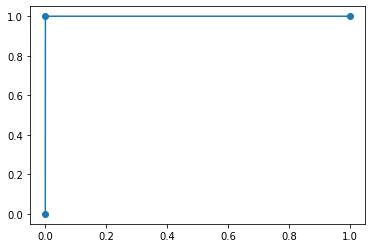

AUC is 1.0.


In [16]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_predict, pos_label=1)
plt.plot(fpr,tpr,marker = 'o')
plt.show()
from sklearn.metrics import auc
AUC = auc(fpr, tpr)
print ("AUC is {}.".format(round(recall,4)))

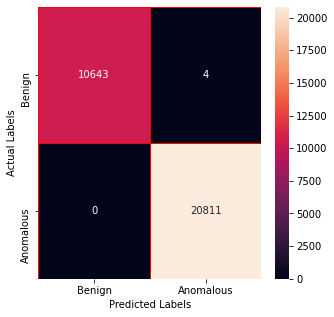

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
cm = confusion_matrix(y_val, y_predict)

class_labels = ['Benign', 'Anomalous']
plot_labels = {"xticklabels": class_labels, 
               "yticklabels": class_labels}

f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True, linewidth =0.5, linecolor ="red", fmt =".0f", ax=ax, **plot_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()


In [18]:
pipe.get_params()['knn'].p

2

In [81]:
# Write the Pipeline to file
import pickle
with open("knnmodel.pkl", "wb") as file
    pickle.dump(pipe, file)

['knnmodel.pickle']

In [83]:
# Read Pipeline from file
loaded_model = joblib.load("knnmodel.pickle")

In [84]:
loaded_model == pipe

False

## Feature Importante Post-training

In [18]:
from sklearn.feature_selection import RFE
pipe['knn'].features_importances_
# features_ranking = RFE(pipe)

AttributeError: 'KNeighborsClassifier' object has no attribute 'features_importances_'

## Test Data A.K.A. Company's Data

In [ ]:
predictions_test = pipe.predict(company_df)
predictions_test

In [ ]:
# Create a new label column based off the predictions
convert_to_classlabels = lambda value : 'BENIGN' if value == 0 else 'ANOMALOUS'
company_df['Label'] = list(map(convert_to_classlabels, predictions_test))
company_df.head()

## Final Result

In [ ]:
# Count
company_df.Label.value_counts()